In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classification-of-malwares/ClaMP_Integrated-5184.csv
/kaggle/input/classification-of-malwares/ClaMP_Raw-5184.csv


# Testing the major dimensionality reduction techniques on a new dataset - The malware classification dataset from the location : 
#### https://www.kaggle.com/saurabhshahane/classification-of-malwares  

In [2]:
dataset = pd.read_csv(r"../input/classification-of-malwares/ClaMP_Integrated-5184.csv")

#------------------------------------------------------------------------------------------------
#Summary
print('Total Shape :',dataset.shape)
dataset.head()

Total Shape : (5210, 70)


,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,...,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,...,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,...,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,...,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,...,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


# Pre-Processing the data to enable one-hot encoding on the categorical columns

In [3]:
type_df = pd.DataFrame(dataset.dtypes).reset_index()
type_df.columns=['cols','type']
type_df[type_df['type']=='object']['cols'].unique()

#------------------------------------------------------------------------------------
print('Total unique values in "packer_type":',dataset['packer_type'].nunique())
#------------------------------------------------------------------------------------
#Extracting the required levels only, based on value counts. 
packer_unique_df = pd.DataFrame(dataset['packer_type'].value_counts()).reset_index()
packer_unique_df.columns = ['packer_type','unique_count']
catg = packer_unique_df[packer_unique_df['unique_count']>10]['packer_type'].unique()
#------------------------------------------------------------------------------------
encoded = pd.get_dummies(dataset['packer_type'])
encoded = encoded[[col for col in list(encoded.columns) if col in catg]]
print('Shape of encode :',encoded.shape)
#------------------------------------------------------------------------------------
#Concatenating the encoded columns
if set(catg).issubset(set(dataset.columns))==False: #Conditional automation 
    dataset = pd.concat([dataset,encoded],axis=1)
    dataset.drop(columns='packer_type',inplace=True)

dataset.shape


Total unique values in "packer_type": 40
Shape of encode : (5210, 9)


(5210, 78)

# Separating the target column for our analysis (Since it is an dependent column in this use-case) and scaling the data (standard scaler)

In [4]:
from sklearn.preprocessing import StandardScaler

target='class'
cols_to_keep = [cols for cols in list(dataset.columns) if target not in cols]
dataset_modified = dataset[cols_to_keep]
ads_arr_y = np.array(dataset[target])

ads_arr_scaled = StandardScaler().fit_transform(dataset_modified)
print(ads_arr_scaled.shape)
ads_arr_scaled[0]

(5210, 77)


array([-0.01404635, -0.01943837, -0.01948361,  0.07939496, -0.01913298,
        0.68263322, -0.34480506,  0.0984374 , -0.75450455,  0.        ,
       -0.94799159, -0.9483566 , -0.01385552, -0.1461792 , -0.25453179,
        0.05373446, -0.13701094, -0.10329208, -0.10329208,  0.        ,
        1.61108136,  0.        , -0.25453179,  0.05353879, -0.50381603,
       -0.00738157, -0.02090132, -0.02567289,  0.94125303, -0.05004687,
        0.81832782, -2.56372277,  0.        ,  0.        , -0.61824884,
       -0.47590596, -0.06902628, -0.06346983,  0.55952963,  0.76811781,
        0.14271718,  0.06802826, -0.01323518,  1.63595415,  1.43252862,
       -0.08571613, -0.64181315, -0.01385552, -0.44587386,  0.        ,
        0.        , -0.62307524, -0.05001443, -0.01385552,  0.        ,
       -0.2042605 , -0.08413996, -0.23535331, -0.24246624,  0.03099379,
       -0.22222011, -0.26342809, -0.43062512,  0.65992463,  1.08719007,
        0.0744291 ,  0.23468632,  0.91528275, -0.17452467, -0.14

# PCA (Principal Components Analysis)

In [5]:
from sklearn.decomposition import PCA

#------------------------------------------------------
pca = PCA()
principalComponents = pca.fit_transform(ads_arr_scaled)
principalComponents.shape

(5210, 77)

### Explaining the variance distribution among the principal components

[Text(0.5, 0, 'Principal Component'),
 Text(0, 0.5, 'explained_variance_in_ratio'),
 Text(0.5, 1.0, 'Explained-variance vs Component Chart')]

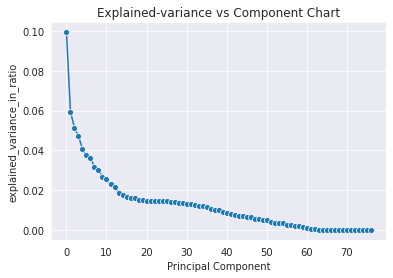

In [6]:
explained_var_ratio = pca.explained_variance_ratio_ #The explained variance for each principal component

#Plotting
sns.set_style('darkgrid')
ax = sns.lineplot(x=range(len(explained_var_ratio)),y=explained_var_ratio,marker='o')
ax.set(xlabel='Principal Component',ylabel='explained_variance_in_ratio',title='Explained-variance vs Component Chart')

### Finding the total PCs to achieve 95% explained variance

In [7]:
var_sum = 0
max_var = 0.95
for idx in range(len(explained_var_ratio)):
    var_sum += explained_var_ratio[idx]
    if var_sum>max_var:
        break

#-----------------------------------------------------------------
print('Total Variance explained :',100 * var_sum,'%')
print('Total PCs to achieve the above explained variance :',idx+1)

Total Variance explained : 95.15921258381546 %
Total PCs to achieve the above explained variance : 47


### Visualizing the first two components on 2-d chart

[Text(0.5, 0, 'Principal Component - 0'),
 Text(0, 0.5, 'Principal Component - 1'),
 Text(0.5, 1.0, 'Principal_Component-0 vs Principal_Component-1')]

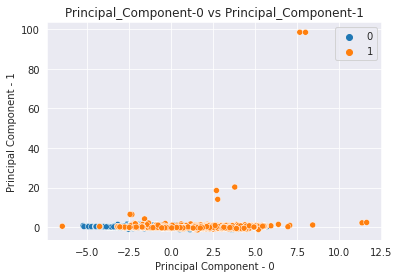

In [8]:
import seaborn as sns

ax = sns.scatterplot(x=principalComponents[:,0],y=principalComponents[:,1],hue=ads_arr_y)
ax.set(xlabel='Principal Component - 0',ylabel='Principal Component - 1',title='Principal_Component-0 vs Principal_Component-1')

### Insight - From the explained ratio we can see that principal component-0:46 explains 95% of the data,hence if we just keep the first 3-4 PCs we take a large hit in terms of information. This is case where Principal Components Analysis is not suitable for dimensionality reduction since we lose out on a lot of information

# t-SNE (Stochastic Neighbor Embedding with t-distribution) 

In [9]:
from sklearn.manifold import TSNE
 
tsne = TSNE(n_components=2,
            perplexity=np.sqrt(np.round(len(ads_arr_scaled),0)),
            learning_rate=1,
            n_iter=1000,
            n_iter_without_progress=300,
            min_grad_norm=1e-7,
            metric='euclidean',
            random_state=100,
            n_jobs=-1) #perplexity=sqrt(n)
 
tsne_embedded = tsne.fit_transform(ads_arr_scaled)

### Visualizing the lower dimensions of t-SNE transformation

[Text(0.5, 0, 'tsne-0'),
 Text(0, 0.5, 'tsne-1'),
 Text(0.5, 1.0, 'tsne-0 vs tsne-1')]

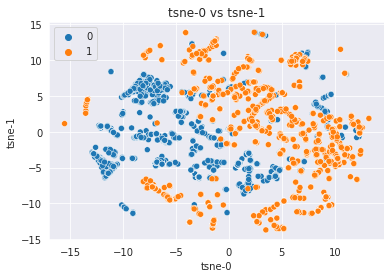

In [10]:
ax = sns.scatterplot(x=tsne_embedded[:,0],y=tsne_embedded[:,1],hue=ads_arr_y)
ax.set(xlabel='tsne-0',ylabel='tsne-1',title='tsne-0 vs tsne-1')

# UMAP (Uniform Manifold Approximation & Projection)

In [11]:
!pip install umap-learn

In [12]:
import umap
 
#---------------------------------------------------------
umap_embedding = umap.UMAP(n_components = 2,
                           n_neighbors=50,
                           min_dist=0.0001,
                           metric='euclidean',
                           random_state=100) #Stochastic Gradient Params not tuned here - Can be tuned 
 
#---------------------------------------------------------
umap_embed = umap_embedding.fit_transform(ads_arr_scaled)
umap_embed.shape

(5210, 2)

### Visualizing the lower dimension after UMAP transformation

[Text(0.5, 0, 'umap-0'),
 Text(0, 0.5, 'umap-1'),
 Text(0.5, 1.0, 'umap-0 vs umap-1')]

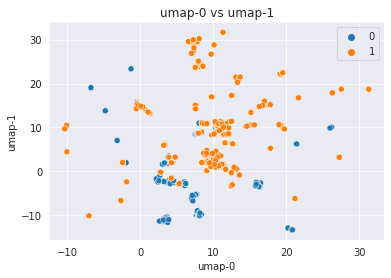

In [13]:
ax = sns.scatterplot(x=umap_embed[:,0],y=umap_embed[:,1],hue=ads_arr_y)
ax.set(xlabel='umap-0',ylabel='umap-1',title='umap-0 vs umap-1')

# 2-d comparison of all techniques 

[Text(0.5, 0, 'umap-0'),
 Text(0, 0.5, 'umap-1'),
 Text(0.5, 1.0, 'umap-0 vs umap-1')]

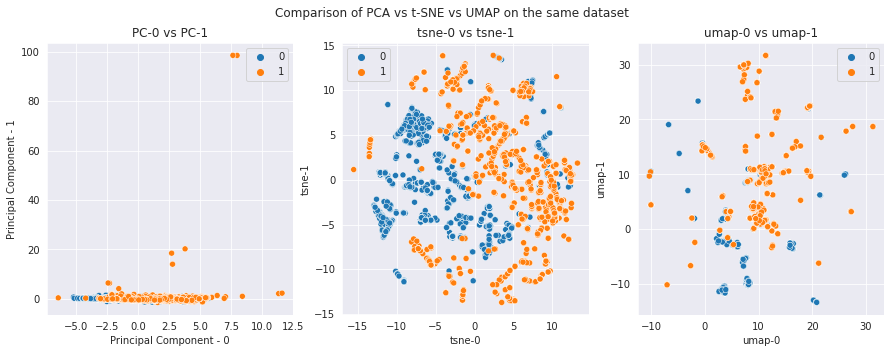

In [14]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15,5))

#-----------------------------------------------------------------------
fig.suptitle('Comparison of PCA vs t-SNE vs UMAP on the same dataset')
axes[0].set_title('2-d PCA projection (Best 2 components)')
axes[1].set_title('2-d t-SNE projection ')
axes[2].set_title('2-d UMAP projection ')
    
#---------------------------------------------------------------------------------------------------------------------------------
ax = sns.scatterplot(ax=axes[0],x=principalComponents[:,0],y=principalComponents[:,1],hue=ads_arr_y)
ax.set(xlabel='Principal Component - 0',ylabel='Principal Component - 1',title='PC-0 vs PC-1')
#---------------------------------------------------------------------------------------------------------------------------------
ax = sns.scatterplot(ax=axes[1],x=tsne_embedded[:,0],y=tsne_embedded[:,1],hue=ads_arr_y)
ax.set(xlabel='tsne-0',ylabel='tsne-1',title='tsne-0 vs tsne-1')
#---------------------------------------------------------------------------------------------------------------------------------
ax = sns.scatterplot(ax=axes[2],x=umap_embed[:,0],y=umap_embed[:,1],hue=ads_arr_y)
ax.set(xlabel='umap-0',ylabel='umap-1',title='umap-0 vs umap-1')

# Insights : 
1. For Malware dataset, PCA isnt able to capture any pattern in the data since each principal component has very less explained variance ratio
2. t-SNE and UMAP have shown some promise in plotting better 2-d plots but UMAP seems to induce much more noise than t-SNE

# END